In [45]:
import numpy as np
import pandas as pd

Cleaning train dataset

In [46]:
train_df = pd.read_csv("./twitter_training.csv")
absurd = train_df.columns[3]

train_df.rename(columns = {
    'Positive' : 'Label',
    absurd : 'text'
}, inplace=True)

train_df.drop(columns=['Borderlands', '2401'], inplace=True)
train_df.head()

,Label,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [47]:
train_df['Label'].value_counts()

Label
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [48]:
print(f"Null Rows:\n{train_df.isnull().sum()}\n")
print(f"Duplicated Rows: {int(train_df.duplicated().sum())}")


Null Rows:
Label      0
text     686
dtype: int64

Duplicated Rows: 4909


In [49]:
print(f"Percentage of Empty and duplicated rows: {round(
    int(train_df.isnull().sum()['text'] + train_df.duplicated().sum()) * 100 / len(train_df),
    3)} %")


Percentage of Empty and duplicated rows: 7.492 %


#### Since the empty and duplicated needs to be delt with, we shall drop it

In [50]:
train_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True)

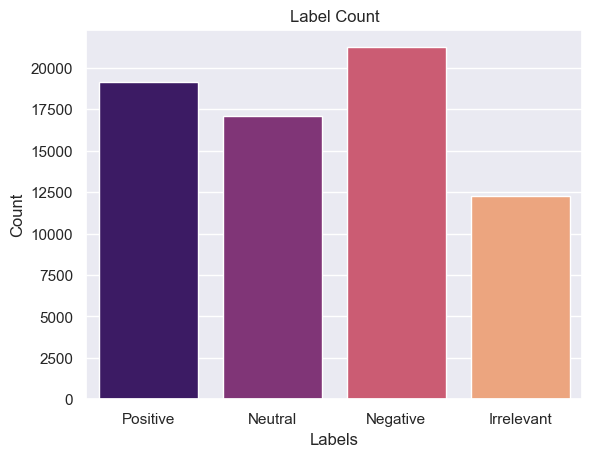

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = 'darkgrid')
sns.countplot(data = train_df, x=train_df['Label'], hue=train_df['Label'], palette='magma')
plt.title('Label Count')
plt.ylabel('Count')
plt.xlabel('Labels')
plt.show()

#### Encoding the Labels

In [52]:
train_df['Sentiment'] = train_df['Label'].replace({
    'Irrelevant' : 0,
    'Neutral' : 1,
    'Negative' : 2,
    'Positive' : 3 
})
train_df.head()

C:\Users\mayan\AppData\Local\Temp\ipykernel_7804\1263614908.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['Sentiment'] = train_df['Label'].replace({


,Label,text,Sentiment
0,Positive,I am coming to the borders and I will kill you...,3
1,Positive,im getting on borderlands and i will kill you ...,3
2,Positive,im coming on borderlands and i will murder you...,3
3,Positive,im getting on borderlands 2 and i will murder ...,3
4,Positive,im getting into borderlands and i can murder y...,3


Cleaning validation dataset

In [53]:
val_df = pd.read_csv('./twitter_validation.csv')
absurd2 = val_df.columns[3]
val_df.rename(columns = {
    'Irrelevant' : 'Label',
    absurd2 : 'text'
}, inplace=True)
val_df.drop(columns=['Facebook', '3364'], inplace=True)
val_df['Sentiment'] = val_df['Label'].replace({
    'Irrelevant' : 0,
    'Neutral' : 1,
    'Negative' : 2,
    'Positive' : 3 
})

val_df.head()

C:\Users\mayan\AppData\Local\Temp\ipykernel_7804\4054578065.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_df['Sentiment'] = val_df['Label'].replace({


,Label,text,Sentiment
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,1
1,Negative,@Microsoft Why do I pay for WORD when it funct...,2
2,Negative,"CSGO matchmaking is so full of closet hacking,...",2
3,Neutral,Now the President is slapping Americans in the...,1
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,2


In [54]:
val_df.duplicated().sum()

1

In [55]:
val_df.isnull().sum()

Label        0
text         0
Sentiment    0
dtype: int64

In [56]:
val_df.shape

(999, 3)

# MODEL TIME!!!

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

# Set batch size (you can adjust this based on your GPU memory)
BATCH_SIZE = 4

# Initialize BERT tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Function to convert data to InputExample format
def convert_data_to_examples(data, text_field, label_field):
    examples = []
    for i, row in data.iterrows():
        example = InputExample(
            guid=None,
            text_a=row[text_field],
            text_b=None,
            label=row[label_field]
        )
        examples.append(example)
    return examples

# Function to convert examples to features
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []
    
    for ex in examples:
        input_dict = tokenizer.encode_plus(
            ex.text_a,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=True
        )
        
        input_ids, token_type_ids, attention_mask = (
            input_dict["input_ids"],
            input_dict["token_type_ids"],
            input_dict["attention_mask"]
        )
        
        features.append(
            InputFeatures(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                label=ex.label
            )
        )
    
    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )
    
    return tf.data.Dataset.from_generator(
        gen,
        ({
            "input_ids": tf.int32,
            "attention_mask": tf.int32,
            "token_type_ids": tf.int32,
        }, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

# Convert your preprocessed data to InputExamples and then to TF dataset
train_examples = convert_data_to_examples(train_df, 'text', 'Sentiment')
val_examples = convert_data_to_examples(val_df, 'text', 'Sentiment')

train_data = convert_examples_to_tf_dataset(train_examples, tokenizer)
train_data = train_data.shuffle(100).batch(BATCH_SIZE).repeat(2)

val_data = convert_examples_to_tf_dataset(val_examples, tokenizer)
val_data = val_data.batch(BATCH_SIZE)

# Load BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=4)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Add early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_data,
    epochs=3,
    validation_data=val_data
)

# Print training summary
print("\nTraining complete!")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")